In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
       # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
import os


def load_and_preprocess_jpg(data_dir, img_size=(64, 64)):

    # Gather all JPG files from the directory
    image_paths = [os.path.join(data_dir, img) for img in os.listdir(data_dir) if img.endswith(('.jpg', '.jpeg', '.png'))]

    # Define preprocessing function
    def preprocess_image(file_path):
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)  # Decode image as RGB
        img = tf.image.resize(img, img_size)  # Resize to desired size
        img = (img / 127.5) - 1.0  # Normalize pixel values to [-1, 1]
        return img

    # Create a TensorFlow dataset for efficient processing
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)

    # Collect all processed images into a numpy array
    all_images = []
    for batch in dataset:
        all_images.extend(batch.numpy())
    
    return np.array(all_images)

# Load Monet and Photo images
monet_dir = '/kaggle/input/gan-getting-started/monet_jpg'  
photo_dir = '/kaggle/input/gan-getting-started/photo_jpg'  

monet_images = load_and_preprocess_jpg(monet_dir)
photo_images = load_and_preprocess_jpg(photo_dir)

# Check the shapes of the datasets
print("Shape of Monet images:", monet_images.shape)  # (n_samples, 64, 64, 3)
print("Shape of Photo images:", photo_images.shape)

Shape of Monet images: (300, 64, 64, 3)
Shape of Photo images: (7038, 64, 64, 3)


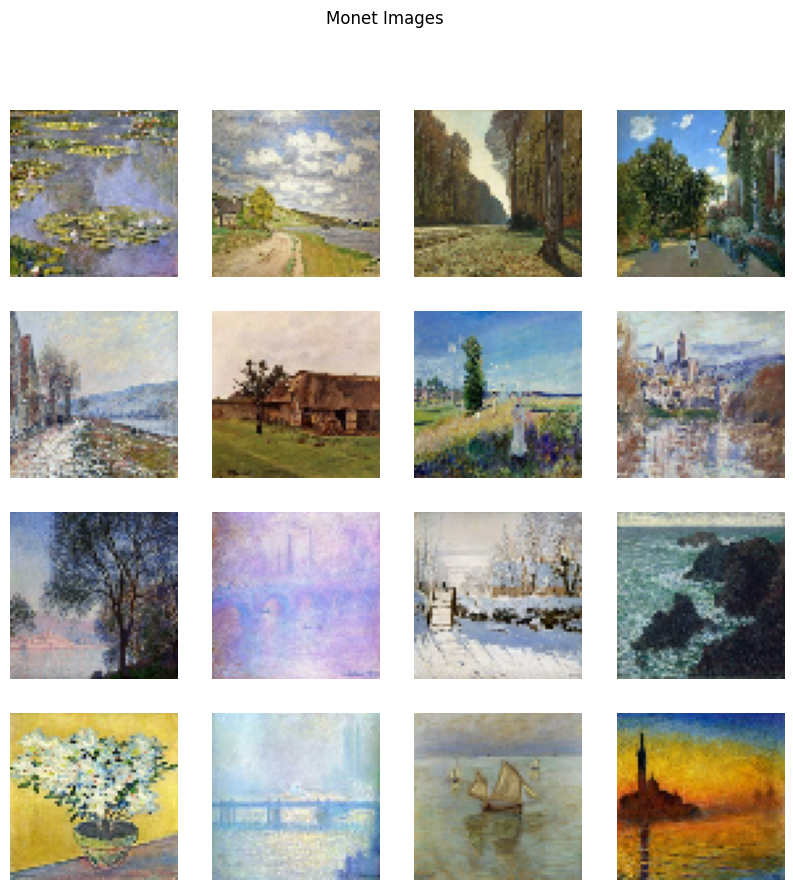

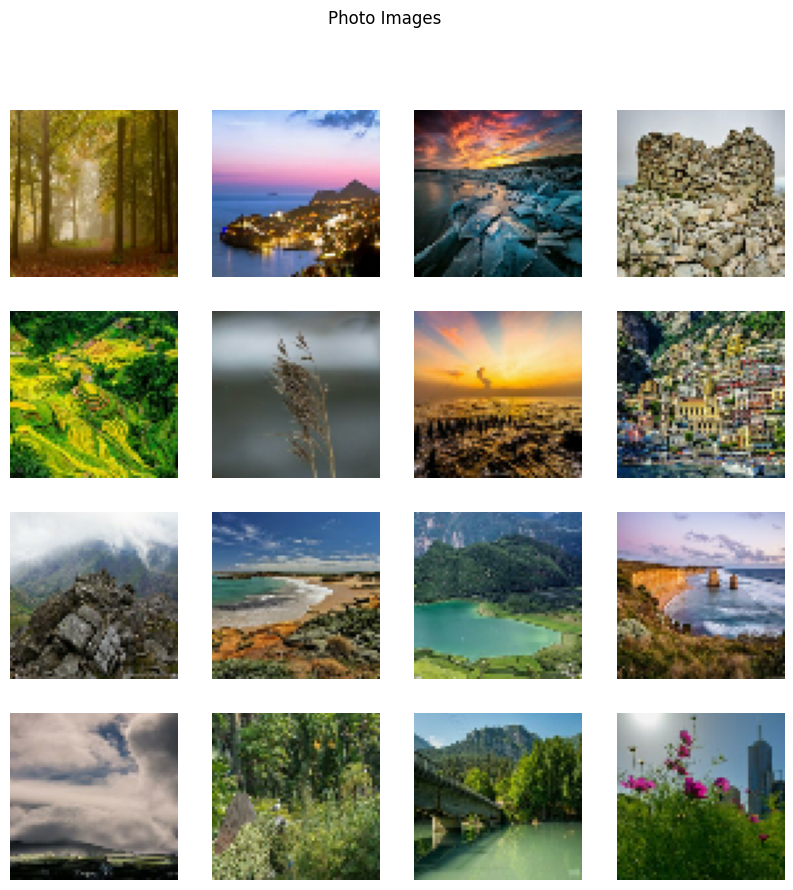

In [3]:
import matplotlib.pyplot as plt

def plot_sample_images(images, title="Sample Images"):
    plt.figure(figsize=(10, 10))
    for i in range(16):  # Display first 16 images
        plt.subplot(4, 4, i + 1)
        plt.imshow((images[i] + 1) / 2)  # Rescale [-1, 1] back to [0, 1] for display
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Visualize Monet and Photo images
plot_sample_images(monet_images, title="Monet Images")
plot_sample_images(photo_images, title="Photo Images")


In [4]:
from tensorflow.keras import layers

# Generator model
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(256, input_dim=100, activation="relu"),
        layers.BatchNormalization(momentum=0.8),
        layers.Dense(512, activation="relu"),
        layers.BatchNormalization(momentum=0.8),
        layers.Dense(1024, activation="relu"),
        layers.BatchNormalization(momentum=0.8),
        layers.Dense(64*64*3, activation="tanh"), 
        layers.Reshape((64, 64, 3))
    ])
    return model

# Discriminator model
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Flatten(input_shape=(64, 64, 3)),
        layers.Dense(512, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    return model

# GAN setup
def build_gan(generator, discriminator):
    discriminator.trainable = False  # Freeze discriminator during generator training
    gan_input = layers.Input(shape=(100,))
    generated_image = generator(gan_input)
    gan_output = discriminator(generated_image)
    return tf.keras.Model(gan_input, gan_output)

# Compile models
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(optimizer=tf.keras.optimizers.Adam(0.0002, 0.5), loss="binary_crossentropy", metrics=["accuracy"])

gan = build_gan(generator, discriminator)
gan.compile(optimizer=tf.keras.optimizers.Adam(0.0002, 0.5), loss="binary_crossentropy")

# Training
def train_gan(generator, discriminator, gan, epochs, batch_size, data):
    half_batch = batch_size // 2
    for epoch in range(epochs):
        # Train discriminator
        idx = np.random.randint(0, data.shape[0], half_batch)
        real_images = data[idx]
        noise = np.random.normal(0, 1, (half_batch, 100))
        generated_images = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_images, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(generated_images, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.ones((batch_size, 1))  # Labels for generated images as valid
        g_loss = gan.train_on_batch(noise, valid_y)

        # Print losses
        print(f"{epoch}/{epochs}, D loss: {d_loss[0]}, G loss: {g_loss}")

        # Save generated samples every few epochs
        if epoch % 100 == 0:
            save_images(epoch, generator)

# Helper to save generated images
def save_images(epoch, generator):
    noise = np.random.normal(0, 1, (10, 100))  # Generate 10 images
    gen_images = generator.predict(noise)
    gen_images = 0.5 * gen_images + 0.5  # Rescale images [0, 1]

    fig, axs = plt.subplots(1, 10, figsize=(20, 2))
    for i in range(10):
        axs[i].imshow(gen_images[i])
        axs[i].axis("off")
    plt.savefig(f"generated_images_epoch_{epoch}.png")
    plt.close()


# Begin training process
train_gan(generator, discriminator, gan, epochs=800, batch_size=64, data=monet_images)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0/800, D loss: 0.7528501152992249, G loss: [array(0.7455472, dtype=float32), array(0.7455472, dtype=float32), array(0.171875, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/800, D loss: 0.7378349304199219, G loss: [array(0.73996043, dtype=float32), array(0.73996043, dtype=float32), array(0.1875, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/800, D loss: 0.7312517166137695, G loss: [array(0.7333085, dtype=float32), array(0.7333085, dtype=float32), array(0.21354167, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3/800, D loss: 0.7345184087753296, G loss: [array(0.7396195, dtype=float32), array(0.7396195, dtype=float32), array(0.22265625, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4/800, D loss: 0.7511380910873413, G loss: [array(0.75935525, dtype=float32), array(0.75935525, dtype=float32), array(0.2125, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
5/800, D loss: 0.766425609588623, G loss: [array(0.777099

In [ ]:
import zipfile
from PIL import Image

# Define paths
output_dir = "../tmp/generated_images"  
os.makedirs(output_dir, exist_ok=True)
zip_path = "images.zip"

def save_generated_images(generator, num_images=7000, img_size=(256, 256), zip_path=zip_path):

    # Initialize zip file
    with zipfile.ZipFile(zip_path, mode="w") as img_zip:
        for i in range(num_images):
            # Generate random noise
            noise = np.random.normal(0, 1, (1, 100))  
            generated_img = generator.predict(noise)[0]  

            # Rescale to [0, 255] and convert to uint8
            generated_img = (generated_img + 1) * 127.5
            generated_img = np.clip(generated_img, 0, 255).astype(np.uint8)

            # Resize to 256x256
            img = tf.image.resize(generated_img, img_size)

            # Rescale, cast, and adjust the shape
            generated_img = (generated_img + 1) * 127.5 
            generated_img = tf.image.resize(generated_img, img_size)  
            generated_img = tf.clip_by_value(generated_img, 0, 255)  
            generated_img = tf.cast(generated_img, tf.uint8) 
            
            # If needed, expand dimensions for PIL
            generated_img = generated_img.numpy()
            
            # Convert to PIL Image for saving
            img = Image.fromarray(generated_img)

            # Save the image temporarily
            image_name = f"monet_image_{i + 1}.jpg"
            temp_path = os.path.join(output_dir, image_name)
            img.save(temp_path, format="JPEG")

            # Add to zip file
            img_zip.write(temp_path, arcname=image_name)

            # Clean up temporary file to save disk space
            os.remove(temp_path)

    print(f"Generated {num_images} images and saved them to {zip_path}.")

# Call the function with the trained generator
save_generated_images(generator, num_images=8000)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━